<a href="https://colab.research.google.com/github/palash04/Artificial-Intelligence/blob/master/Neural_Networks/Intro_to_Pytorch/_02_HandwrittenDigitRecognition_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets,transforms
from torch import nn, optim

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

- **transforms.ToTensor()** — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
- **transforms.Normalize()** — normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

In [12]:
# Downloading the datasets
# Shuffle them and transform each one of them

trainset = datasets.MNIST('~/.pytorch/MNIST_data',download=True,train=True,transform = transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data',download=True,train=False,transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

# Batch size is the number of images we want to read in one go

In [20]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print (images.shape)
print (labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


- The shape of images which is torch.Size([64, 1, 28, 28]) suggests that in one batch there are 64 images, with color channel as 1, and each image has a dimension of 28x28 pixels.
- The shape of labels is torch.Size([64]) which is for 64 images in the batch.

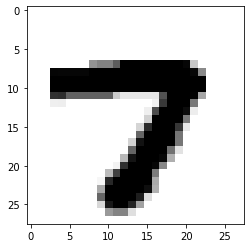

In [22]:
# Displaying one image from the dataset

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

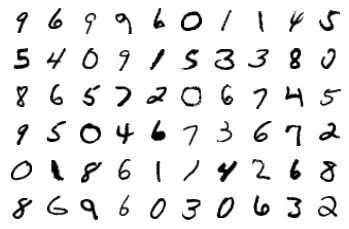

In [32]:
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Building the neural network
![Screenshot 2020-07-01 at 10 00 02](https://user-images.githubusercontent.com/26361028/86203073-a3b5d700-bb81-11ea-9e58-1d93f3ca95d2.png)


PyTorch’s torch.nn module allows us to build the above network very simply.

In [33]:
input_size = 784      # 784 because we flatten out the image i.e 28 x 28 = 784
hidden_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size,hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1],output_size),
                      nn.LogSoftmax(dim=1),
                      )

print (model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


The nn.Sequential wraps the layers in the network. There are three linear layers with ReLU activation ( a simple function which allows positive values to pass through, whereas negative values are modified to zero ). The output layer is a linear layer with LogSoftmax activation because this is a classification problem.

Technically, a LogSoftmax function is the logarithm of a Softmax function

![Screenshot 2020-07-01 at 10 04 36](https://user-images.githubusercontent.com/26361028/86203290-4706ec00-bb82-11ea-9a5c-f9429cc9d80b.png)


Next, we define the negative log-likelihood loss. It is useful to train a classification problem with C classes. Together the LogSoftmax() and NLLLoss() acts as the cross-entropy loss as shown in the network architecture diagram above.

In [35]:
criterion = nn.NLLLoss()
images,labels = next(iter(trainloader))
images = images.view(images.shape[0],-1)

logps = model(images)   # log probabilities
loss = criterion(logps,labels)  # calculate the NLL loss
print (loss)

tensor(2.3549, grad_fn=<NllLossBackward>)


### Adjusting weights
A neural network learns by iterating multiple times over the available data. The terms learn refers to the adjustment of weights of the network to minimize the loss.

In [36]:
print ('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print ('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0078, -0.0078, -0.0078,  ..., -0.0078, -0.0078, -0.0078],
        ...,
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [ 0.0053,  0.0053,  0.0053,  ...,  0.0053,  0.0053,  0.0053],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011]])


# Core Training Process
This is where the actual magic happens. Your neural network iterates over the training set and updates the weights. We make use of torch.optim which is a module provided by PyTorch to optimize the model, perform gradient descent and update the weights by back-propagation. Thus in each epoch (number of times we iterate over the training set), we will be seeing a gradual decrease in training loss.

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
time0 = time()
epochs = 15
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    # Flattening images
    images = images.view(images.shape[0],-1)

    # Training pass
    optimizer.zero_grad()

    output = model(images)
    loss = criterion(output,labels)

    # Backpropagate
    loss.backward()

    # Optimize the weights
    optimizer.step()

    running_loss += loss.item()
  
  print ('Epoch {} - Training loss: {}'.format(e,running_loss/len(trainloader)))

print ('\nTraining time (in minutes) = ', (time() - time0)/60)

Epoch 0 - Training loss: 0.12624317119374617
Epoch 1 - Training loss: 0.12013763151784886
Epoch 2 - Training loss: 0.11398777912563479
Epoch 3 - Training loss: 0.10857373618407608
Epoch 4 - Training loss: 0.10331249743926404
Epoch 5 - Training loss: 0.09866303250964072
Epoch 6 - Training loss: 0.09437341919677185
Epoch 7 - Training loss: 0.09034820895856505
Epoch 8 - Training loss: 0.08633282415862721
Epoch 9 - Training loss: 0.08299035097716619
Epoch 10 - Training loss: 0.07976984464204007
Epoch 11 - Training loss: 0.07670844305775312
Epoch 12 - Training loss: 0.07332229214126686
Epoch 13 - Training loss: 0.07037379960172069
Epoch 14 - Training loss: 0.06764646638869874

Training time (in minutes) =  2.5972460389137266


## Testing and Evaluating


In [39]:
images, labels = next(iter(testloader))

images.shape

torch.Size([64, 1, 28, 28])

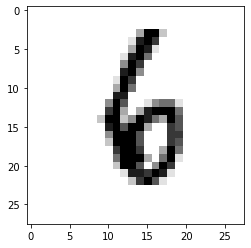

In [62]:
# Let's plot the first image in this batch
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')

In [63]:
img = images[1].view(1,784)
img.shape

torch.Size([1, 784])

In [64]:
with torch.no_grad():
  logps = model(img)

In [65]:
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print('Predicted digit = ', probab.index(max(probab)))

Predicted digit =  6


As we see the digit is correctly predicted by the model.
Now we will test for the entire test set

In [68]:
correct_count, all_count = 0,0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1,784)
    with torch.no_grad():
      logps = model(img)
    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    prediction_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if (true_label == prediction_label):
      correct_count += 1
    all_count += 1

print ('Number of Images tested = ', all_count)
print ('\nModel Accuracy = ', (correct_count/all_count))

Number of Images tested =  60000

Model Accuracy =  0.9756666666666667


We got over 97.5% accuracy
The reason we got such a high accuracy was that our data-set was clean, had a variety of well-shuffled images and a large number of them. This made our model well prepared to recognize a large number of unseen digits.

# Saving the model -
### so that we can reuse it later instead of going through all the training process again and again.

In [79]:
torch.save(model, '/content/drive/My Drive/Artificial Intelligence/trained_mnist_model.pt') 

# Loading the model from drive

In [81]:
path = '/content/drive/My Drive/Artificial Intelligence/trained_mnist_model.pt'
model = torch.load(path)

In [85]:
# Checking if the model is successfully loaded

images,labels = next(iter(testloader))
print (images.shape)

torch.Size([64, 1, 28, 28])


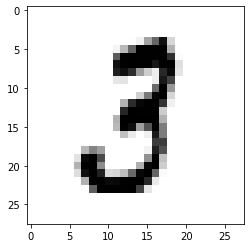

In [86]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [87]:
# Let's see if the model predicts 3

In [88]:
img = images[0].view(1,784)

In [89]:
img.shape

torch.Size([1, 784])

In [91]:
with torch.no_grad():
  logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
predicted_digit = probab.index(max(probab))

In [92]:
print ("Prediction: ", predicted_digit)

Prediction:  3


##### Voila!!!!